### Домашня работа 2.
### Логистическая регрессия. Работа с признаками


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Можно получить 4.5 бонусных балла.

Неэффективная реализация кода может негативно отразиться на оценке.

In [ ]:
print('Всем удачи!👒 Тут она точно пригодится.')

Всем удачи!👒 Тут она точно пригодится.


In [ ]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Логистическая регрессия своими руками (4 балла)

Реализуйте логистическую регрессию, обучаемую с помощью:

**Задание 1 (1.5 балла). Градиентного спуска**

**Задание 2 (1.5 балла). Стохастического градиентного спуска**

Во всех пунктах необходимо соблюдать следующие условия:
- Градиентный спуск необходимо записать в векторном виде
- Циклы средствами python допускается использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

        проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) задаваемого параметром `tolerance`;


        достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса loss_history. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);

Инициализировать веса можно случайным образом или нулевым вектором.

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

градиент функции logloss записанные в матричном виде $X^{T}(\sigma(XW)-Y)$

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator
from tqdm import tqdm_notebook
from scipy.special import expit as sigm

class MyLogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3, eta=1e-2, batch_size=1):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        loss_history: save losses at each iteration
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.batch_size = batch_size

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        if y is None:
            raise ValueError('Requires y to be passed, but the target y is None')
        if self.w0 is None:
          self.w0 = np.random.rand(X.shape[1])

        self.w=self.w0.copy()

        for iter_num in range(self.max_iter):
          grad = self.calc_gradient(X, y)
          if (np.linalg.norm(self.eta*grad) < self.tolerance):
            return self
          # движение в негативную сторону вычисляемого градиента
          self.w = self.w - self.eta * grad
          loss = self.calc_loss(X,y)
          self.loss_history.append(loss)

        return self


    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        y_hat = 1/(1+np.exp(-np.dot(X,self.w)))
        return y_hat


    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        y_hat_proba = self.predict_proba(X)

        return [1 if p > 0.5 else 0 for p in y_hat_proba]

    def calc_gradient(self, X_orig, y_orig):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        #определимс с типом градиента
        if self.gd_type == "full":
          y =y_orig
          X=X_orig
        elif self.gd_type=="stochastic":
          #создадим случайные индексы выбираемых объектов
          ind = np.random.randint(X_orig.shape[0], size=self.batch_size)
          X=X_orig[ind]
          y=y_orig[ind]
        else:
          raise Exception("Unknown type of gradient")
        #посчитаем градиент
        y_pred = self.predict_proba(X)
        grad = -(X.T @ (y-y_pred))/ len(y)
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """

        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        #get predictions
        y_pred = self.predict_proba(X)
        #использую logloss, так как он корректно штрафует + выпуклый
        #чтобы избежать 0 в логарифме добавим минимальное значение

        logloss_1 = np.sum(np.log(y_pred[y==1]+1e-30))
        logloss_0 = np.sum(np.log(1-y_pred[y==0]+1e-30))
        loss = -(logloss_0 + logloss_1) / len(y)
        return loss

Синтетические данные

In [ ]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [ ]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

**Задание 3 (1 балл)**

Обучите логистическую регрессию на синтетических данных.

In [ ]:
test1 = MyLogReg(gd_type='full')
test2 = MyLogReg(gd_type='stochastic', batch_size=5)

test1.fit(X_train, y_train)
test2.fit(X_train, y_train)

y_pred1 = test1.predict(X_test)
y_pred2 = test2.predict(X_test)

accuracy1 =(y_pred1 == y_test).sum() / len(y_test)
accuracy2 =(y_pred2 == y_test).sum() / len(y_test)

print(f"Accuracy for full gradient: {accuracy1}")
print(f"Accuracy for stohastic gradient: {accuracy2}")


Accuracy for full gradient: 0.8485666666666667
Accuracy for stohastic gradient: 0.7755


In [ ]:
#Проверка на sklearn
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(tol=1e-4, max_iter=1000,)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy =(y_pred == y_test).sum() / len(y_test)
print(f"Accuracy for sklearn regression: {accuracy}")

Accuracy for sklearn regression: 0.8486666666666667


На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

#roc-auc
model_test1 = test1.predict_proba(X_test)
model_test2 = test2.predict_proba(X_test)
model_sklearn = logreg.predict_proba(X_test)[:, 1]

#посчитаем
lr_probs1 = roc_auc_score(y_test, model_test1)
lr_probs2 = roc_auc_score(y_test, model_test2)
lr_probs_sklearn = roc_auc_score(y_test, model_sklearn)

#Результат
print('ROC AUC for full gradient=%.3f' % (lr_probs1))
print('ROC AUC for stohastic gradient=%.3f' % (lr_probs2))
print('ROC AUC for sklearn=%.3f' % (lr_probs_sklearn))

print("___________________________________")

#pr-auc
precision_test1, recall_test1, _ = precision_recall_curve(y_test, model_test1)
precision_test2, recall_test2, _ = precision_recall_curve(y_test, model_test2)
precision_sklearn, recall_sklearn, _ = precision_recall_curve(y_test, model_sklearn)

#посчитаем
pr_auc_test1 = auc(recall_test1, precision_test1)
pr_auc_test2 = auc(recall_test2, precision_test2)
pr_auc_sklearn = auc(recall_sklearn, precision_sklearn)

#Результат
print('PR-AUC for full gradient=%.3f' % (pr_auc_test1))
print('PR-AUC for stohastic gradient=%.3f' % (pr_auc_test2))
print('PR-AUC for sklearn=%.3f' % (pr_auc_sklearn))




ROC AUC for full gradient=0.926
ROC AUC for stohastic gradient=0.853
ROC AUC for sklearn=0.926
___________________________________
PR-AUC for full gradient=0.924
PR-AUC for stohastic gradient=0.859
PR-AUC for sklearn=0.925


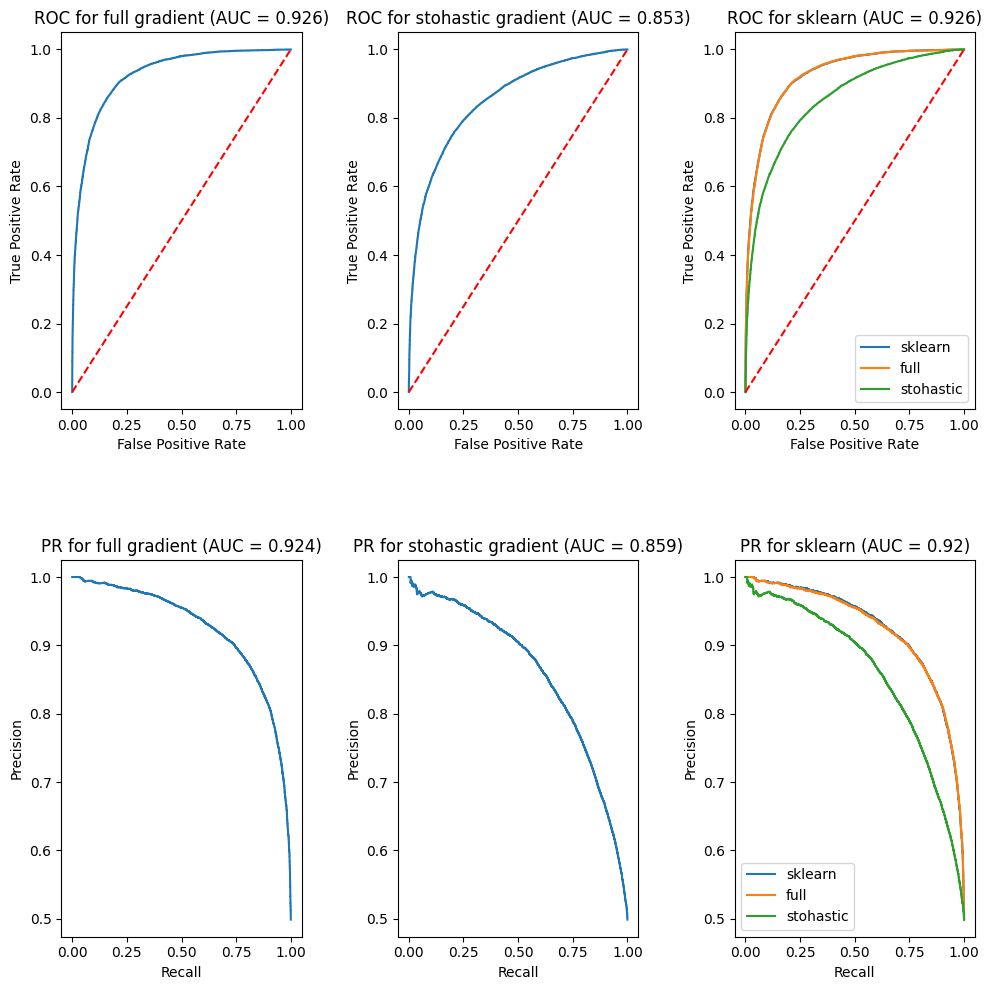

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))

# Построение ROC curve
fpr_test1, tpr_test1, _ = roc_curve(y_test, model_test1)
axes[0][0].plot(fpr_test1, tpr_test1)
axes[0][0].plot([0, 1], [0, 1], 'r--')
axes[0][0].set_xlabel('False Positive Rate')
axes[0][0].set_ylabel('True Positive Rate')
axes[0][0].set_title(f'ROC for full gradient (AUC = {lr_probs1:.3f})')

fpr_test2, tpr_test2, _ = roc_curve(y_test, model_test2)
axes[0][1].plot(fpr_test2, tpr_test2)
axes[0][1].plot([0, 1], [0, 1], 'r--')
axes[0][1].set_xlabel('False Positive Rate')
axes[0][1].set_ylabel('True Positive Rate')
axes[0][1].set_title(f'ROC for stohastic gradient (AUC = {lr_probs2:.3f})')

fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, model_sklearn)
axes[0][2].plot(fpr_sklearn, tpr_sklearn, label="sklearn")
axes[0][2].plot(fpr_test1, tpr_test1, label="full")
axes[0][2].plot(fpr_test2, tpr_test2, label="stohastic")
axes[0][2].plot([0, 1], [0, 1], 'r--')
axes[0][2].set_xlabel('False Positive Rate')
axes[0][2].set_ylabel('True Positive Rate')
axes[0][2].set_title(f'ROC for sklearn (AUC = {lr_probs_sklearn:.3f})')
axes[0][2].legend(loc='lower right')

# Построение PR curve
axes[1][0].plot(recall_test1, precision_test1)
axes[1][0].set_xlabel('Recall')
axes[1][0].set_ylabel('Precision')
axes[1][0].set_title(f'PR for full gradient (AUC = {pr_auc_test1:.3f})')

axes[1][1].plot(recall_test2, precision_test2)
axes[1][1].set_xlabel('Recall')
axes[1][1].set_ylabel('Precision')
axes[1][1].set_title(f'PR for stohastic gradient (AUC = {pr_auc_test2:.3f})')

axes[1][2].plot(recall_sklearn, precision_sklearn, label="sklearn")
axes[1][2].plot(recall_test1, precision_test1, label="full")
axes[1][2].plot(recall_test2, precision_test2, label="stohastic")
axes[1][2].set_xlabel('Recall')
axes[1][2].set_ylabel('Precision')
axes[1][2].set_title(f'PR for sklearn (AUC = {pr_auc_sklearn:.2f})')
axes[1][2].legend(loc='lower left')

plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.4)


## **Выводы**:  
Хуже всего себя показывает модель стохастического градиентного спуска. Для вычислений стохастического градиентного спуска использовалось разбиение на подвыборку (batch_size = 5). Результаты экспериментов показали, что меньшая подвыборка дает еще более худший результат. А большая подвыборка идентична градиентному спуску.  
При этом мы видим, что full gradient идентичен по реультатам модели sklearn.


## Часть 2. Работа с категориальными переменными (3 балла)

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом для задания мы немного модифицируем датасет.

In [ ]:
data = pd.read_csv('/content/train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [ ]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

**Задание 5 (0 баллов).** Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
my_model = MyLogReg(gd_type='full')
my_model.fit(X_train, y_train)
y_pred_my = my_model.predict_proba(X_test)

print('ROC-AUC (my) = {}'.format(roc_auc_score(y_test, y_pred_my)))


ROC-AUC (my) = 0.5114844981653768


In [ ]:
#sklearn продолжаю сравнивать со своей моделью
model = LogisticRegression(max_iter=1000, solver='sag')
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

print('ROC-AUC (sklearn) = {}'.format(roc_auc_score(y_test, y_pred)))

ROC-AUC (sklearn) = 0.6250654322009421


**Задание 6 (0.5 балла).** Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
#примем за категорииальные признаки те, которые по описанию имеют в названии cat
cols = [col for col in X_train.columns if 'cat' in col]

X_train_ohe = pd.get_dummies(X_train, columns=cols, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, columns=cols, drop_first=True)

In [ ]:
X_train_ohe.shape

(100000, 212)

In [ ]:
import time
from statistics import mean

test_time_my=[]
test_time_sk=[]

start_time_my = time.time()
my_model = MyLogReg(gd_type='full')
my_model.fit(X_train_ohe, y_train)
end_time_my=time.time()
test_time_my.append(end_time_my-start_time_my)

start_time_sk = time.time()
sk_model = LogisticRegression(max_iter=1000, solver='sag')
sk_model.fit(X_train_ohe, y_train)
end_time_sk=time.time()
test_time_sk.append(end_time_sk-start_time_sk)

y_prob_my = my_model.predict_proba(X_test_ohe)
y_prob_sk = sk_model.predict_proba(X_test_ohe)[:, 1]

#посчитаем
lr_probs = roc_auc_score(y_test, y_prob_my)
lr_probs_sk = roc_auc_score(y_test, y_prob_sk)

#Результат
print('ROC AUC for full gradient = %.3f' % (lr_probs))
print('ROC AUC for sklearn = %.3f' % (lr_probs_sk))
print("---------------------")
print("Average time for my model: ", mean(test_time_my))
print("Average time for sklearn model: ", mean(test_time_sk))





ROC AUC for full gradient = 0.555
ROC AUC for sklearn = 0.633
---------------------
Average time for my model:  457.9560978412628
Average time for sklearn model:  353.269348859787


**Выводы:** Время выполнения моей моделью и моделью sklearn в разы отличается. Но качество собственной модели улучшилось на 3 сотых, а вот качество модели sklearn, при тех же параметрах, улучшилось только на  сотую.

Как можно было заменить, one-hot-кодирование сильно увилечивает количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 7 (1.5 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментом. Заметили ли вы что-то интересное?


In [ ]:
def calc_smooth_mean(df, on, y, size):
  """
  df: DataFrame
  on: Column name
  y: Target frame
  size: размер колонки
  """

  #считаем категории в колонке
  cat_list = np.unique(df[on])
  #создаем шаблон для значений
  counts = np.zeros(size)

  for cat in cat_list:
    #Считаем числитель - количество объектов категории с таргетом +1
    numerator = np.sum(np.equal(df[on], cat) & y == 1)
    #считаем знаменатель - обзее количество объектов по категории
    denominator = np.sum(np.equal(df[on], cat))
    #вычисляем среднее
    smooth = numerator/denominator

    #записываем значения по категории в наш шаблон, чтобы его подложить в фрейм
    counts[df[on]==cat]=smooth

  return counts

In [ ]:
X_train_counts = X_train.copy()
X_test_counts = X_test.copy()

for col in cols:
  X_train_counts.loc[:, col] = calc_smooth_mean(X_train, col, y_train, np.size(X_train[col]))
  X_test_counts.loc[:, col] = calc_smooth_mean(X_train, col, y_train, np.size(X_test[col]))

In [ ]:
test_time_my=[]
test_time_sk=[]

start_time_my = time.time()
my_model = MyLogReg(gd_type='full')
my_model.fit(X_train_counts, y_train)
end_time_my=time.time()
test_time_my.append(end_time_my-start_time_my)

start_time_sk = time.time()
sk_model = LogisticRegression(max_iter=10000, solver='sag')
sk_model.fit(X_train_counts, y_train)
end_time_sk=time.time()
test_time_sk.append(end_time_sk-start_time_sk)

y_prob_my = my_model.predict_proba(X_test_counts)
y_prob_sk = sk_model.predict_proba(X_test_counts)[:, 1]

#посчитаем
lr_probs = roc_auc_score(y_test, y_prob_my)
lr_probs_sk = roc_auc_score(y_test, y_prob_sk)

#Результат
print('ROC AUC for full gradient = %.3f' % (lr_probs))
print('ROC AUC for sklearn = %.3f' % (lr_probs_sk))
print("---------------------")
print("Average time for my model: ", mean(test_time_my))
print("Average time for sklearn model: ", mean(test_time_sk))

ROC AUC for full gradient = 0.544
ROC AUC for sklearn = 0.579
---------------------
Average time for my model:  176.07866382598877
Average time for sklearn model:  180.4179413318634


**Выводы:** В этот раз модели обучились быстрее, чем при one-hot. При этом качество моделей ухудшилось в сравнении с OHE.Для самописной модели ухудшение незначительное, только 1 сотая. А вот модель sklearn сильно ухудшилась.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо так, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

__Задание 8 (1 балл)__. Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def calc_noise_mean(df, on, y, size):
  """
  df: DataFrame
  on: Column name
  y: Target frame
  size: размер колонки
  """

  cat_list = np.unique(df[on])
  counts = np.zeros(size)

  for cat in cat_list:
    #Считаем числитель - количество объектов категории с таргетом +1
    numerator = np.sum(np.equal(df[on], cat) & y == 1)
    #считаем знаменатель - обзее количество объектов по категории
    denominator = np.sum(np.equal(df[on], cat))
    noise = np.random.normal(0, 0.0001, 1)
    #вычисляем среднее
    smooth = (numerator/denominator)+noise

    #записываем значения по категории в наш шаблон, чтобы его подложить в фрейм
    counts[df[on]==cat]=smooth

  # Replace each value by the according smoothed mean
  return counts

In [ ]:
X_train_noise = X_train.copy()
X_test_noise = X_test.copy()

for col in cols:
  X_train_noise.loc[:, col] = calc_noise_mean(X_train, col, y_train, np.size(X_train[col]))
  X_test_noise.loc[:, col] = calc_noise_mean(X_train, col, y_train, np.size(X_test[col]))

In [ ]:
test_time_my=[]
test_time_sk=[]

start_time_my = time.time()
my_model = MyLogReg(gd_type='full')
my_model.fit(X_train_noise, y_train)
end_time_my=time.time()
test_time_my.append(end_time_my-start_time_my)

start_time_sk = time.time()
sk_model = LogisticRegression(max_iter=10000, solver='sag')
sk_model.fit(X_train_noise, y_train)
end_time_sk=time.time()
test_time_sk.append(end_time_sk-start_time_sk)

y_prob_my = my_model.predict_proba(X_test_noise)
y_prob_sk = sk_model.predict_proba(X_test_noise)[:, 1]

#посчитаем
lr_probs = roc_auc_score(y_test, y_prob_my)
lr_probs_sk = roc_auc_score(y_test, y_prob_sk)

#Результат
print('ROC AUC for full gradient = %.3f' % (lr_probs))
print('ROC AUC for sklearn = %.3f' % (lr_probs_sk))
print("---------------------")
print("Average time for my model: ", mean(test_time_my))
print("Average time for sklearn model: ", mean(test_time_sk))

ROC AUC for full gradient = 0.545
ROC AUC for sklearn = 0.579
---------------------
Average time for my model:  174.34487748146057
Average time for sklearn model:  178.73768496513367


**Вывод:** качество и время выполнения остались примерно на том же уровне, что и на этапе ранее (без добавления шума).

## Часть 3. Отбор признаков (3 балла + 1 бонус)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом они увеличивают время вычислений) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [ ]:
data = pd.read_csv('/content/train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
cols = [col for col in X_train.columns if 'cat' in col]

X_train_ohe = pd.get_dummies(X_train, columns=cols, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, columns=cols, drop_first=True)

In [ ]:
X_train_ohe.shape

(476169, 213)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
my_model = MyLogReg(gd_type='full')
my_model.fit(X_train_ohe, y_train)

#для sklearn использую также solver='sag', так как на большой выборке без этого Colab падает
sk_model = LogisticRegression(max_iter=10000, solver='sag')
sk_model.fit(X_train_ohe, y_train)

y_prob_my = my_model.predict_proba(X_test_ohe)
y_prob_sk = sk_model.predict_proba(X_test_ohe)[:, 1]

#посчитаем
roc_auc_my = roc_auc_score(y_test, y_prob_my)
roc_auc_sk = roc_auc_score(y_test, y_prob_sk)

#Результат
print('ROC AUC for full gradient = %.3f' % (roc_auc_my))
print('ROC AUC for sklearn = %.3f' % (roc_auc_sk))

ROC AUC for full gradient = 0.535
ROC AUC for sklearn = 0.638


### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 10 (1 балл).__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

Использование [f-regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression)

In [ ]:
#использую SelectKBest - removes all but the K highest scoring features
#также использую модель обученную выше - sk_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

test_time=[]
start_time_sk = time.time()
fs = SelectKBest(score_func=f_regression, k=200)

X_train_200 = pd.DataFrame(fs.fit_transform(X_train_ohe, y_train))
X_test_200 = pd.DataFrame(fs.transform(X_test_ohe))
end_time_sk=time.time()
test_time.append(end_time_sk-start_time_sk)
print("Скорость отбора признаков: ", mean(test_time))

Скорость отбора признаков:  1.5868988037109375


In [ ]:
test_time=[]

start_time_sk = time.time()
sk_model = LogisticRegression(max_iter=10000, n_jobs = -1, tol = 0.1, solver='sag')
sk_model.fit(X_train_200, y_train)
end_time_sk=time.time()
test_time.append(end_time_sk-start_time_sk)

y_prob_sk = sk_model.predict_proba(X_test_200)[:, 1]

#посчитаем
lr_probs = roc_auc_score(y_test, y_prob_sk)

#Результат
print("Скорость обучения на отобранных признаках: ", mean(test_time))
print("ROC AUC: ", lr_probs)


Скорость обучения на отобранных признаках:  12.44307541847229
ROC AUC:  0.6374951639934501


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train_ohe))
X_test_sc = pd.DataFrame(scaler.transform(X_test_ohe))

In [ ]:
#посмотрим на модель без отбора признаков
without_selection = LogisticRegression(max_iter=10000, n_jobs = -1, tol = 0.1, solver='sag')
without_selection.fit(X_train_sc, y_train)
y_prob_without = without_selection.predict_proba(X_test_sc)[:, 1]
res_without = roc_auc_score(y_test, y_prob_without)

#и на модель с отбором признаков
fs = SelectKBest(score_func=f_regression, k=200)
X_train_200_sc = pd.DataFrame(fs.fit_transform(X_train_sc, y_train))
X_test_200_sc = pd.DataFrame(fs.transform(X_test_sc))

with_selection = LogisticRegression(max_iter=10000, n_jobs = -1, tol = 0.1, solver='sag')
with_selection.fit(X_train_200_sc, y_train)
y_prob_with = with_selection.predict_proba(X_test_200_sc)[:, 1]
res_with = roc_auc_score(y_test, y_prob_with)

print('ROC AUC без отбора признаков: = %.3f' % (res_without))
print('ROC AUC с отбором признаков: = %.3f' % (res_with))


ROC AUC без отбора признаков: = 0.637
ROC AUC с отбором признаков: = 0.635


**Выводы**:
модели обучаются за считанные секунды. Но вот ROC AUC на нормированных данных практически идентично, что с отбором признаков, что без.

__Задание 10 (0.5 балла).__
Можно задать отбор признаков более функционально. Вспомним, что L1-регуляризация также умеет отбирать признаки. Понятно, что теперь нам будет сложнее оставить именно 200 лучших признаков, но возможно они нам и не нужны. Подберите коэффициент регуляризации и проверьте, как изменилось качество. Получилось ли добиться лучшего качества при менее чем 200 признаках?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
#На всякий случай обновим данные
cols = [col for col in X_train.columns if 'cat' in col]

X_train_ohe = pd.get_dummies(X_train, columns=cols, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, columns=cols, drop_first=True)

scaler = MinMaxScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train_ohe))
X_test_sc = pd.DataFrame(scaler.transform(X_test_ohe))

про подбор [регуляризации](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
lr_cv = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=np.linspace(0.001, 0.01, 30), refit=True)
lr_cv = lr_cv.fit(X_train_sc, y_train)
print(np.count_nonzero(lr_cv.coef_))

8


**Вывод**: мы получили только 8 ненулевых коеэффициентов из 213.

In [ ]:
indices = np.where(np.abs(lr_cv.coef_[0]) < 1e-6)[0]
X_train_l = X_train_sc.drop(indices, axis = 1)
X_test_l = X_test_sc.drop(indices, axis = 1)

X_test_l.shape

(119043, 8)

In [ ]:
model = LogisticRegression(max_iter=1000, n_jobs = -1, penalty='l1', tol = 0.1, solver='liblinear')
model.fit(X_train_l, y_train)
y_prob = model.predict_proba(X_test_l)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

print('ROC AUC с отбором L1: = %.3f' % (roc_auc))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


ROC AUC с отбором L1: = 0.606


**Вывод**: Модель, обученная на 8 признаках из 213 чуть менее эффективна, чем модель обученная на 200 признаках.

### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $mu$, $sigma$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

Если у вас был курс математической статистики, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях. Если же нет, то интуиция следующая. Вообще мы хотим понять, различаются ли распределения признака для двух разных классов. Мы проверяем, что математические ожидания двух распределений различаются. Если они различаются, значит и сами распределения разные. Отсюда можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и статистика маленькая, то и признак бесполезен.

Важно оговориться, что хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и n велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются. По-хорошему, конечно, надо бы сравнивать статистику с пороговым значением t-распределения и полноценно тестировать гипотезу, но мы обойдёмся простой эвристикой и возьмём признаки с наибольшим значением.


__Задание 11 (1 балл)__. Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случаев.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def calc_t(X, y):
    #Разделим данные по классам
    X_positive = X[y == 1]
    X_negative = X[y == 0]

    #Считаем количество
    n_positive = len(X_positive)
    n_negative = len(X_negative)

    #Считаем среднее
    mu_positive = np.mean(X_positive, axis=0)
    mu_negative = np.mean(X_negative, axis=0)

    #Считаем сренеквадратичное
    sigma_positive = np.std(X_positive, axis=0)
    sigma_negative = np.std(X_negative, axis=0)

    numerator = np.abs(mu_positive - mu_negative)
    denominator=(n_positive * sigma_positive ** 2 + n_negative * sigma_negative ** 2) / (n_positive + n_negative)
    t =  numerator/np.sqrt(denominator)

    indices = np.argsort(t)[::-1]

    return t, indices

In [ ]:
#Получим индексы наиболее весомых признаков
test_time=[]
start_time = time.time()
t_statistics, indices = calc_t(X_train_sc, y_train)

#Посмотрим, что это были за колонки
selected_columns = X_train_sc.columns[indices[:200]]
X_train_tstat = X_train_sc[selected_columns]
X_test_tstat = X_test_sc[selected_columns]
end_time=time.time()
test_time.append(end_time-start_time)
print("Скорость отбора признаков: ", mean(test_time))

Скорость отбора признаков:  3.4491336345672607


In [ ]:
model = LogisticRegression(max_iter=1000, n_jobs = -1, tol = 0.1, solver='sag')
model.fit(X_train_tstat, y_train)
y_prob = model.predict_proba(X_test_tstat)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

print('ROC AUC с T статистикой: = %.3f' % (roc_auc))

ROC AUC с T статистикой: = 0.635


### Методы-обёртки

__Задание 12 (бонус, 1 балл)__.


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


**Задание 13 (0.5 балла)** Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

**Ответ:**  
*Методы фильтрации*:  
"+"

*   Относительно быстрые - встроенные методы рассчитывают быстрее;
*   Легко интерпретируемый результат.
  
  
"-"
  
*   Не учитывается взаимосвязь между признаками, а также с целевой переменной.
   

*Встроенные методы*:  
"+"


*   Достаточно быстрые (кроме регуляризации).
*   Учитывается модель - признаки отбираются на основе указанной модели.


  